# TODO: WARUM homogene Koordinaten????

# Theoretischer Hintergrund

Wir betrachten eine Teilmenge $Q(d)$ des $d$-dimensionalen Euklidischen Raums $E(d)$, bestehend aus den Punkten, deren Kartesische Koordinaten rationale Zahlen sind. 

Ein Punkt in $Q(d)$ kann als Liste von $d+1$ ganzen Zahlen $[x_0, x_1, . . . , x_d ]$ mit $x_d \neq 0$, dargestellt werden (homogene Koordinaten). 
Diese Liste repräsentiert die $d$ rationalen Kartesischen Koordinaten $[x_0/x_d , x_1/x_d , . . . , x_{d−1}/xd]$
.

Ein Punkt in $Q(d)$ ist eine Liste von ganzen Zahlen:
```Haskell
type Point = [Integer]
```

## Simplex
Ein $d$-Simplex ist die Verallgemeinerung eines Dreiecks in $d$-Dimensionen.
![Simplex](img/simplex.PNG)
Ein $d$-Simplex kann als Liste von $d+1$ Punkten in $Q(d)$ und einem Wert $+1$ oder $-1$, der die Orientierung des Simplex angibt, repräsentiert werden:
```Haskell

type Simplex = ([Point], Int)
```

## Konvexe Menge
Jedes $d$-Simplex $smp$ bestimmt eine konvexe Menge $CS(smp)$ in $Q(d)$. 

Eine Teilmenge des euklidischen Raums (geometrische Figur) ist konvex, wenn für je zwei beliebige Punkte, die zur Menge gehören, auch stets deren Verbindungsstrecke ganz in der Menge liegt.
![konvexe Menge](img/cm1.PNG)

Der Bereich enthält die Punkte innerhalb von $smp$ und auf dessen Grenze.

Um zu bestimmen ob ein Punkt innerhalb oder auf $CS(smp)$ liegt, müssen die Facetten von $smp$ berechnet werden.

## Facette
Die Facette eines $d$-Simplex kann als Liste von $d$ Punkten und einer dazugehörigen Orientierung (abgeleitet von dem Simplex), dargestellt werden. 
Beispielsweise sind die Facetten einer Kante ihre zwei Endpunkte, die Facetten eines Dreiecks sind ihre drei Kanten.

```Haskell

type Facet = ([Point], Int)
```

### Beispiel
Ein Dreieck $[a,b,c]$ mit positiver Orientierung im $Q(2)$ hat drei Facetten $([b, c], +1)$, $([a, c],−1)$, $([a, b], +1)$. 
Ein Punkt $p$ befindet sich innerhalb von $[a,b,c]$, wenn die drei Simplexe $ [p, b, c]$, $[p, a, c]$ und $[p, a, b]$ die Orientierungen $+1$, $−1$ und $+1$ haben. 

Implikation:
- $p$ befindet sich links von der Kante $b$ nach $c$
- $p$ befindet sich rechts von der Kante $a$ nach $c$
- $p$ befindet sich links von der Kante $a$ nach $b$

![Triangle](img/triangle1.PNG)

## Konvexe Hülle
Die konvexe Hülle $CH(vs)$ einer Punktmenge $vs$ in $Q(d)$ entspricht einem Bereich in $Q(d)$ und kann wie folgt definiert werden:
- $CH(vs)$ ist die **Vereinigung** der Mengen $CS(smp)$ über alle $d$-Simplexe $smp$, die wiederum durch Punkte $vs$ bestimmt werden

In $Q(2)$ bestimmt sich die konvexe Hülle der Punkte $vs$ durch die **Vereinigungsmenge** der Bereiche, die durch alle Dreiecke deren Eckpunkte innerhalb von $vs$ liegen. 

Die Menge $CH(vs)$ lässt sich dementsprechend durch folgendes Prädikat charakterisieren:
```Haskell

insideCH :: [Point] -> Point -> Bool
insideCH vs p = or [insideCS smp p | smp <- simplexes vs]
```
![Konvexe Hülle](img/ch.PNG)
Das Bild zeigt die konvexe Hülle von Punkten in der Ebene. Sie besteht aus dem schwarz umrandeten Gebiet (inklusive Rand).

# Determinanten
Die Determinantenberechnungen stammen aus der *Functional Pearl: Three ways of computing determinants* und werden bei der Ermittlung der *Orientierung* benötigt.

In [1]:
minors :: [a] -> [[a]]
minors [] = []
minors (x : xs) = xs : map (x :) (minors xs)

In [2]:
det :: [[Integer]] -> Integer
det [[x ]] = x
det xss = foldr1 (-) (zipWith (*) col1 (map det (minors cols)))
          where col1 = map head xss
                cols = map tail xss

In [3]:
matrix = [[2,2,1],[9,2,5],[3,7,3]]
det matrix

-25

In [4]:
-- A more fancy Determinant calculation based on Integer Division
det :: [[Integer]] -> Integer
det [[x]] = x
det xss =
  case break ((/= 0) . head) xss of
   (yss, [ ]) -> 0
   (yss, zs : zss) -> let x = det(condense(zs : yss ++ zss))
                          d = head zs ^ (length xss - 2)
                          y = x `div` d
                      in if even (length yss) then y else -y

condense = map (map det . pair . uncurry zip) . pair
           where pair (x : xs) = map ((, ) x ) xs
                 det ((a, b), (c, d)) = a * d - b * c

Line 13: Use tuple-section
Found:
((,) x)
Why not:
(x,)

In [5]:
matrix = [[2,2,1],[9,2,5],[3,7,3]]
det matrix

-25

# Konvexe Hüllen

In [6]:
import Data.List

type Point = [Integer]
type Simplex = ([Point], Int)
type Facet = ([Point], Int)

dimension :: Point -> Int
dimension ps = length ps - 1

orientation :: [Point] -> Int
orientation = fromIntegral . signum . det

facets :: Simplex -> [Facet]
facets (us, b) = zip (minors us) (cycle [b, -b])

insideCS :: Simplex -> Point -> Bool
insideCS smp p = and [0 <= b * orientation (p : us) | (us, b) <- facets smp]

In [7]:
-- Excercise:
-- The value of tuples n vs is a list of all n-tuples of vs; that is, all subsequences
-- of vs of length n. The definition of tuples is left as an exercise.

tuples' :: Int -> [a] -> [[a]]
tuples' n vs = filter (\x -> length x == n) (subsequences vs)

tuples :: Int -> [a] -> [[a]]
tuples n = filter ((==n) . length) . subsequences

tuples 2 [[1,2], [3,4], [5,6], [7,8]]

[[[1,2],[3,4]],[[1,2],[5,6]],[[3,4],[5,6]],[[1,2],[7,8]],[[3,4],[7,8]],[[5,6],[7,8]]]

In [8]:
insideCH :: [Point] -> Point -> Bool
insideCH vs p = or [insideCS smp p | smp <- simplexes vs]

simplexes :: [Point] -> [Simplex]
simplexes vs = [(us, b) | us <- tuples (d + 1) vs,
                          let b = orientation us, b /= 0]
               where d = dimension (head vs)

## Simplexe finden

Die Funktion `findSimplex` sucht nach einem Simplex. 
Wenn kein Simplex gefunden wird, gibt es keine Partitionierung und es liegt eine leere Hülle vor. 

In [9]:
-- The inefficient variant
findSimplex :: [Point] -> Maybe Simplex
findSimplex vs = if null smps then Nothing 
                 else Just (head smps)
                 where smps = simplexes vs

Im schlimmsten Fall benötigt die obige `findSimplex` Funktion $O(n^{d+1})$ Schritte ($n$ ist die Anzahl der Punkte). 
Der Eintritt des Worst Case ist relativ unwahrscheinlich, daher ist die obige Definition für unsere Zwecke ausreichend. 

Die effizientere Variante (siehe unten) benötigt nur $O(d^{d+3}n)$ Schritte. 

In [10]:
-- The more efficient variant
findSimplex :: [Point] -> Maybe Simplex
findSimplex [] = Nothing
findSimplex (v : vs) = search (length v - 1) 1 [v] vs

search d k us vs
  | k == d + 1 = Just (us, orientation us)
  | null vs = Nothing
  | degenerate k (v : us) = search d k us (tail vs)
  | otherwise = search d (k + 1) (v : us) (tail vs)
    where v = head vs

submatrices k vs = map (++[last vs]) (tuples k (init vs))
degenerate k = all (==0) . map det . submatrices k . transpose

## Updates

Man betrachte eine Menge Simplexe $smps$, welche die konvexe Hülle der bisher betrachteten Punkte partitionieren. 

Die Facetten dieser Simplexe können entweder *intern* oder *extern* sein. 
- *Intern*: Treten genau zweimal mit unterschiedlichen Orientierungen auf
- *Extern*: Treten genau einmal auf (Randfacetten)


- Die externen Facetten werden mit der Funktion `external` ermittelt. 
- Für den Punkt $v$ ist eine Facette $(us, b)$ sichtbar, wenn sich $v$ außerhalb der Facette befindet. 
    - D.h. die Orientierung des Punkts $(v : us)$ hat ein anderes Vorzeichen als die Orientierung der Facette $(us, b)$. 
    - Liegt der Punkt innerhalb der aktuellen konvexen Hülle, gibt es keine sichtbaren Facetten. 
- `newSimplex`: Bei einem update der Hülle wird ein neues Simplex für jede sichtbare Facette hinzugefügt. 



In [11]:
external :: [Simplex] -> [Facet]
external = foldr op [] . sort . concatMap facets
                       
op :: Facet -> [Facet] -> [Facet]
op smp []     = [smp]  -- bug fixed
op smp (smp' : smps) = if vertices smp == vertices smp' then smps 
                       else smp : smp' : smps
                       
visible :: Point -> [Facet] -> [Facet]
visible v fs = [(us, b) | (us, b) <- fs, b * orientation (v : us) < 0]

newSimplex :: Point -> Facet -> Simplex
newSimplex v (us, b) = (v : us, -b)

update :: [Simplex] -> Point -> [Simplex]
update smps v = smps ++ map (newSimplex v) (visible v (external smps))

vertices :: Simplex -> [Point]
vertices = sort . fst

## Ein effizienterer Algorithmus

Für $n$ Punkte gibt es $O (n^{d+1})$ mögliche $d$-Simplexe. 

Um den Ausdruck `insideCH vs p` zu evaluieren werden also $O (n^{d+1})$ Schritte benötigt. 

Allerdings überschneiden sich viele Simplexe. 

Man muss daher nur eine Teilmenge betrachten, welche die Hülle ohne Überschneidung abdeckt.  

Diese Erkenntnis bildet die Basis für einen effizienteren Algorithmus. 

Die Idee hier: 
- Ersetze die Funktion `simplexes` durch die Funktion `partition`, welche die konvexe Hülle aufteilt
- `partition` beginnt mit einem einzelnen Simplex und fügt weitere Simplexe hinzu, sobald sich ein neuer Punkt außerhalb der aktuell aufgespannten Hülle befindet

In [12]:
insideCH' :: [Point] -> Point -> Bool
insideCH' vs p = or [insideCS smp p | smp <- partition vs] 

partition :: [Point] -> [Simplex]
partition vs
    = case findSimplex vs of
        Nothing -> []
        Just smp -> foldl update [smp] (vs \\ vertices smp) -- Bug fix
        -- Just [smp] -> foldl update [smp] (vs \\ vertices smp)

Wird ein Simplex gefunden, dann wird dieses als Startpunkt verwendet und dessen Eckpunkte werden aus der Liste zusätzlich zu betrachtender Punkte entfernt (Listendifferenz).

## Ein noch effizienterer Algorithmus

In [13]:
-- Bug fix: Here we have to call the faces function on vs
insideCH'' vs p = not (null fs) && and [0 <= b * orientation (p : us) | (us, b) <- fs]
                  where fs = faces vs
 
-- Bug fix: Here we have to replace Just [smp] -> foldl update' (facets smp) (vs \\ vertices vs) by the below expression
faces :: [Point] -> [Facet]
faces vs = case findSimplex vs of
           Nothing -> []
           Just smp  -> foldl update' (facets smp) (vs \\ vertices smp)
 
update' :: [Facet] -> Point -> [Facet]
update' fs v = (fs \\ fs') ++ map (newFacet v) (external fs')
               where fs' = visible v fs
 
newFacet v (us, b) = (v:us, b)

## QuickCheck

In [14]:
import Test.QuickCheck
 
hullPoints :: Int -> Int -> Gen [[Integer]]
hullPoints d 0  = return []
hullPoints d n  = do { p <- point d; ps <- hullPoints d (n-1); return (p:ps) }

point :: Int -> Gen [Integer]
point d = do { xs <- vector d; return (xs ++ [1]) }

prop_Hull :: Int -> Int -> Property
prop_Hull d n =
    forAll (hullPoints d n) $ \vs ->
    forAll (point d) $ \v ->
    insideCH vs v == insideCH' vs v && insideCH vs v == insideCH'' vs v
 
qc = quickCheck (prop_Hull 2 4)
qc

+++ OK, passed 100 tests.

In [20]:
verboseCheck (prop_Hull 2 10)

Passed:
[[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1],[0,0,1]]
[0,0,1]

Passed:
[[1,1,1],[-1,-1,1],[1,0,1],[0,-1,1],[0,-1,1],[-1,0,1],[0,0,1],[-1,1,1],[1,-1,1],[1,0,1]]
[0,-1,1]

Passed:
[[2,2,1],[0,0,1],[-2,-1,1],[1,0,1],[2,1,1],[1,-1,1],[0,-1,1],[2,0,1],[0,1,1],[-1,0,1]]
[0,0,1]

Passed:
[[-2,-1,1],[-2,-1,1],[3,-3,1],[-1,-3,1],[-1,1,1],[2,0,1],[0,2,1],[-3,1,1],[-1,2,1],[-2,-1,1]]
[-2,-1,1]

Passed:
[[1,4,1],[-1,1,1],[2,4,1],[-2,-2,1],[0,0,1],[-1,0,1],[4,0,1],[1,0,1],[-1,4,1],[0,3,1]]
[-1,-3,1]

Passed:
[[1,0,1],[2,4,1],[2,-4,1],[-5,-5,1],[-2,3,1],[-3,3,1],[2,1,1],[0,1,1],[-2,-3,1],[0,5,1]]
[1,-2,1]

Passed:
[[6,-6,1],[-5,3,1],[3,-1,1],[-2,-5,1],[-6,-6,1],[-4,0,1],[-1,3,1],[-5,6,1],[-5,-3,1],[3,2,1]]
[-5,-3,1]

Passed:
[[-7,0,1],[-1,1,1],[-5,3,1],[7,-4,1],[7,-1,1],[2,4,1],[-6,6,1],[-3,-1,1],[-3,0,1],[5,2,1]]
[4,-6,1]

Passed:
[[3,8,1],[1,-5,1],[-7,-2,1],[8,-3,1],[7,1,1],[6,-6,1],[0,-4,1],[3,-8,1],[-1,-4,1],[2,1,1]]
[7,1,1]

Passed:
[[-1,2,1],[8,-7,1],[3,-8,1

### Visualisierung

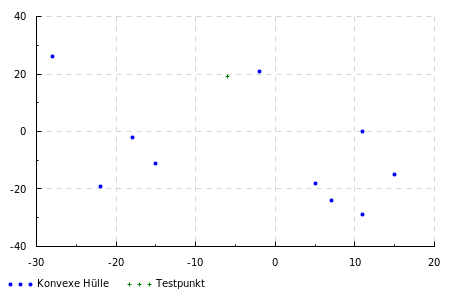

In [21]:
import Graphics.Rendering.Chart.Easy

convexHull = [[-18,-2,1],[7,-24,1],[11,0,1],[-22,-19,1],[11,-29,1],[-28,26,1],[15,-15,1],[-2,21,1],[-15,-11,1],[5,-18,1]]
pt = [-6,19,1]

toRenderable $ do
    plot $ points "Konvexe Hülle" [(x,y) | [x,y,_] <- convexHull]
    plot $ points "Testpunkt" [(x,y) | [x,y,_] <- [pt]]

In [22]:
insideCH convexHull pt

True

In [23]:
insideCH' convexHull pt

True

In [24]:
insideCH'' convexHull pt

True

# Pitfalls
- Determinantenberechnung findet sich in anderer *Functional Pearl*
- `tuples` Funktion muss selbst implementiert werden
- Bug in `partition` Funktion:
     - Das Problem: `Just [smp] -> foldl update [smp] (vs \\ vertices smp)`
     - Lösung: `Just smp -> foldl update [smp] (vs \\ vertices smp)`
- Bug in `op :: Facet -> [Facet] -> [Facet]`:
    - Das Problem: `op smp [] = []`
    - Lösung: `op smp [] = [smp]`